<a href="https://colab.research.google.com/github/yakuzadave/colab-ai-art-gen/blob/main/Art_Generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Google Colab Art Generator Notebook

The goal of this Colab Notebook is to create an easy way to generate art using `CLIP` and `VQGAN`.  While there is some serious work happening under the hood, we are leveraging the Form Params in Colab to make this as easy as possible to just run without needing to add any additional code of your own.



> A big thank you to  [Katherine Crowson](https://github.com/crowsonkb) for all the help with getting this up and running.

-

## The Config

First things first, we will want to take a look at what we will be working with.  This is done by running the following cell.  The `!` in front of the command just means that we are running a shell command and not python.

In [1]:
!nvidia-smi

Thu Jul  7 15:42:32 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    29W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Download the Required Python Packages
---

<br>


Run the cell below to download all the required packages that will be needed. 

<br>

> Don't worry if this takes some time.

In [12]:
#@title Run this cell to download and install the requirements

print("Installing rich for better text format")
!pip install rich                  &> /dev/null
from rich import print, inspect
from rich.progress import Progress
from rich.panel import Panel

print(Panel("[green]Downloading CLIP\nInstalling VQGAN\nInstalling Extra Libraries", title="Configuration Requirements"))
prog = Progress()
task1 = prog.add_task("[green]Git Clone CLIP", total=100)
task2 = prog.add_task("[green]Git Clone Taming Transformers", total=100)
task3 =prog.add_task("[green]Install Python Packages", total=100)
task4 =prog.add_task("[green]Create Directory for Steps", total=100)

prog.console.log("Starting Tasks")
prog.console.log("Cloning CLIP")

!git clone https://github.com/openai/CLIP                 &> /dev/null
prog.update(task1, advance=100)

prog.console.log("Cloning Taming Transformers")

!git clone https://github.com/CompVis/taming-transformers &> /dev/null
prog.update(task2, advance=100)

prog.console.log("Installing Python Packages")
!pip install ftfy regex tqdm omegaconf pytorch-lightning kornia einops wget  python-xmp-toolkit imgtag pillow==7.1.2 imageio-ffmpeg &> /dev/null
prog.update(task1, advance=100)
prog.update(task3, advance=100)
 
 
prog.console.log("Creating Steps Directory")
!mkdir steps
prog.update(task4, advance=100)

prog.console.log("All tasks completed")


Installing rich for better text format

╭─────────────────────────────── Configuration Requirements ────────────────────────────────╮
│ Downloading CLIP                                                                          │
│ Installing VQGAN                                                                          │
│ Installing Extra Libraries                                                                │
╰───────────────────────────────────────────────────────────────────────────────────────────╯

[16:46:39] Starting Tasks                                  <ipython-input-12-bba3e63a717c>:14

           Cloning CLIP                                    <ipython-input-12-bba3e63a717c>:15

           Cloning Taming Transformers                     <ipython-input-12-bba3e63a717c>:20

           Installing Python Packages                      <ipython-input-12-bba3e63a717c>:25

[16:46:43] Creating Steps Directory                        <ipython-input-12-bba3e63a717c>:31

mkdir: cannot create directory ‘steps’: File exists


           All tasks completed                             <ipython-input-12-bba3e63a717c>:35

### Downloading the Models

Next, we are going to be chosing the odels that we want to download.  We have a bunch to choose from.  A good one to start with is `imagenet_16384` but they are all great for different kinds of results.  Just check which ones you want and hit the play button on the cell to get started.


In [18]:
#@title Model Selection
#@markdown ----
#@markdown Select models below (You can select more than one but this will increase download time).

imagenet_1024 = True #@param {type:"boolean"}
imagenet_16384 = True #@param {type:"boolean"}
gumbel_8192 = True #@param {type:"boolean"}
coco = True #@param {type:"boolean"}
wikiart_1024 = True #@param {type:"boolean"}
wikiart_16384 = True #@param {type:"boolean"}
sflckr = True #@param {type:"boolean"}
ade20k = True #@param {type:"boolean"}
ffhq = True #@param {type:"boolean"}
celebahq = True #@param {type:"boolean"}
faceshq = False

print(Panel("[green]Downloading Selected Models", title="Configuration Requirements"))
model_task = prog.add_task("Downloading Models", total=100)



if imagenet_1024:
  prog.update(model_task, advance=10)

  !curl -L -o vqgan_imagenet_f16_1024.yaml -C - 'https://heibox.uni-heidelberg.de/d/8088892a516d4e3baf92/files/?p=%2Fconfigs%2Fmodel.yaml&dl=1' #ImageNet 1024
  prog.update(model_task, advance=10)
  !curl -L -o vqgan_imagenet_f16_1024.ckpt -C - 'https://heibox.uni-heidelberg.de/d/8088892a516d4e3baf92/files/?p=%2Fckpts%2Flast.ckpt&dl=1'  #ImageNet 1024
  prog.update(model_task, advance=10)
if imagenet_16384:
  !curl -L -o vqgan_imagenet_f16_16384.yaml -C - 'https://heibox.uni-heidelberg.de/d/a7530b09fed84f80a887/files/?p=%2Fconfigs%2Fmodel.yaml&dl=1' #ImageNet 16384
  prog.update(model_task, advance=10)

  !curl -L -o vqgan_imagenet_f16_16384.ckpt -C - 'https://heibox.uni-heidelberg.de/d/a7530b09fed84f80a887/files/?p=%2Fckpts%2Flast.ckpt&dl=1' #ImageNet 16384
  prog.update(model_task, advance=10)

if gumbel_8192:
  !curl -L -o gumbel_8192.yaml -C - 'https://heibox.uni-heidelberg.de/d/2e5662443a6b4307b470/files/?p=%2Fconfigs%2Fmodel.yaml&dl=1' #Gumbel 8192
  prog.update(model_task, advance=10)

  !curl -L -o gumbel_8192.ckpt -C - 'https://heibox.uni-heidelberg.de/d/2e5662443a6b4307b470/files/?p=%2Fckpts%2Flast.ckpt&dl=1' #Gumbel 8192
  prog.update(model_task, advance=10)

if coco:
  !curl -L -o coco.yaml -C - 'https://dl.nmkd.de/ai/clip/coco/coco.yaml' #COCO
  prog.update(model_task, advance=10)

  !curl -L -o coco.ckpt -C - 'https://dl.nmkd.de/ai/clip/coco/coco.ckpt' #COCO
  prog.update(model_task, advance=10)

if faceshq:
  !curl -L -o faceshq.yaml -C - 'https://drive.google.com/uc?export=download&id=1fHwGx_hnBtC8nsq7hesJvs-Klv-P0gzT' #FacesHQ
  prog.update(model_task, advance=10)

  !curl -L -o faceshq.ckpt -C - 'https://app.koofr.net/content/links/a04deec9-0c59-4673-8b37-3d696fe63a5d/files/get/last.ckpt?path=%2F2020-11-13T21-41-45_faceshq_transformer%2Fcheckpoints%2Flast.ckpt' #FacesHQ
  prog.update(model_task, advance=10)

if wikiart_1024: 
  !curl -L -o wikiart_1024.yaml -C - 'http://mirror.io.community/blob/vqgan/wikiart.yaml' #WikiArt 1024
  prog.update(model_task, advance=10)

  !curl -L -o wikiart_1024.ckpt -C - 'http://mirror.io.community/blob/vqgan/wikiart.ckpt' #WikiArt 1024
  prog.update(model_task, advance=10)

if wikiart_16384: 
  
  !curl -L -o wikiart_16384.yaml -C - 'http://eaidata.bmk.sh/data/Wikiart_16384/wikiart_f16_16384_8145600.yaml' #WikiArt 16384
  prog.update(model_task, advance=10)

  !curl -L -o wikiart_16384.ckpt -C - 'http://eaidata.bmk.sh/data/Wikiart_16384/wikiart_f16_16384_8145600.ckpt' #WikiArt 16384
  prog.update(model_task, advance=10)

if sflckr:
  !curl -L -o sflckr.yaml -C - 'https://heibox.uni-heidelberg.de/d/73487ab6e5314cb5adba/files/?p=%2Fconfigs%2F2020-11-09T13-31-51-project.yaml&dl=1' #S-FLCKR
  prog.update(model_task, advance=10)

  !curl -L -o sflckr.ckpt -C - 'https://heibox.uni-heidelberg.de/d/73487ab6e5314cb5adba/files/?p=%2Fcheckpoints%2Flast.ckpt&dl=1' #S-FLCKR
  prog.update(model_task, advance=10)

if ade20k:
  !curl -L -o ade20k.yaml -C - 'https://static.miraheze.org/intercriaturaswiki/b/bf/Ade20k.txt' #ADE20K
  prog.update(model_task, advance=10)

  !curl -L -o ade20k.ckpt -C - 'https://app.koofr.net/content/links/0f65c2cd-7102-4550-a2bd-07fd383aac9e/files/get/last.ckpt?path=%2F2020-11-20T21-45-44_ade20k_transformer%2Fcheckpoints%2Flast.ckpt' #ADE20K
  prog.update(model_task, advance=10)

if ffhq:
  !curl -L -o ffhq.yaml -C - 'https://app.koofr.net/content/links/0fc005bf-3dca-4079-9d40-cdf38d42cd7a/files/get/2021-04-23T18-19-01-project.yaml?path=%2F2021-04-23T18-19-01_ffhq_transformer%2Fconfigs%2F2021-04-23T18-19-01-project.yaml&force' #FFHQ
  prog.update(model_task, advance=10)

  !curl -L -o ffhq.ckpt -C - 'https://app.koofr.net/content/links/0fc005bf-3dca-4079-9d40-cdf38d42cd7a/files/get/last.ckpt?path=%2F2021-04-23T18-19-01_ffhq_transformer%2Fcheckpoints%2Flast.ckpt&force' #FFHQ
  prog.update(model_task, advance=10)

if celebahq:
  !curl -L -o celebahq.yaml -C - 'https://app.koofr.net/content/links/6dddf083-40c8-470a-9360-a9dab2a94e96/files/get/2021-04-23T18-11-19-project.yaml?path=%2F2021-04-23T18-11-19_celebahq_transformer%2Fconfigs%2F2021-04-23T18-11-19-project.yaml&force' #CelebA-HQ
  prog.update(model_task, advance=10)
  
  !curl -L -o celebahq.ckpt -C - 'https://app.koofr.net/content/links/6dddf083-40c8-470a-9360-a9dab2a94e96/files/get/last.ckpt?path=%2F2021-04-23T18-11-19_celebahq_transformer%2Fcheckpoints%2Flast.ckpt&force' #CelebA-HQ
  prog.update(model_task, advance=10)


╭─────────────────────────────── Configuration Requirements ────────────────────────────────╮
│ Downloading Selected Models                                                               │
╰───────────────────────────────────────────────────────────────────────────────────────────╯

** Resuming transfer from byte position 645
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
** Resuming transfer from byte position 957954257
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
** Resuming transfer from byte position 692
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--

### Download and Configure Libraries for Running Neural Network

<br>

---

<br>


Go ahead and run this cell below to start downloading the Neural Network that will be used in the next steps.

In [19]:
#@markdown ### Run this cell for Neural Network Config
#@markdown ---- 

import argparse
import math
from pathlib import Path
import sys
 
sys.path.append('./taming-transformers')
from IPython import display
from base64 import b64encode
from omegaconf import OmegaConf
from PIL import Image
from taming.models import cond_transformer, vqgan
import torch
from torch import nn, optim
from torch.nn import functional as F
from torchvision import transforms
from torchvision.transforms import functional as TF
from tqdm.notebook import tqdm
 
from CLIP import clip
import kornia.augmentation as K
import numpy as np
import imageio
from PIL import ImageFile, Image
from imgtag import ImgTag    # metadata 
from libxmp import *         # metadata
import libxmp                # metadata
from stegano import lsb
import json
ImageFile.LOAD_TRUNCATED_IMAGES = True
 
def sinc(x):
    return torch.where(x != 0, torch.sin(math.pi * x) / (math.pi * x), x.new_ones([]))
 
 
def lanczos(x, a):
    cond = torch.logical_and(-a < x, x < a)
    out = torch.where(cond, sinc(x) * sinc(x/a), x.new_zeros([]))
    return out / out.sum()
 
 
def ramp(ratio, width):
    n = math.ceil(width / ratio + 1)
    out = torch.empty([n])
    cur = 0
    for i in range(out.shape[0]):
        out[i] = cur
        cur += ratio
    return torch.cat([-out[1:].flip([0]), out])[1:-1]
 
 
def resample(input, size, align_corners=True):
    n, c, h, w = input.shape
    dh, dw = size
 
    input = input.view([n * c, 1, h, w])
 
    if dh < h:
        kernel_h = lanczos(ramp(dh / h, 2), 2).to(input.device, input.dtype)
        pad_h = (kernel_h.shape[0] - 1) // 2
        input = F.pad(input, (0, 0, pad_h, pad_h), 'reflect')
        input = F.conv2d(input, kernel_h[None, None, :, None])
 
    if dw < w:
        kernel_w = lanczos(ramp(dw / w, 2), 2).to(input.device, input.dtype)
        pad_w = (kernel_w.shape[0] - 1) // 2
        input = F.pad(input, (pad_w, pad_w, 0, 0), 'reflect')
        input = F.conv2d(input, kernel_w[None, None, None, :])
 
    input = input.view([n, c, h, w])
    return F.interpolate(input, size, mode='bicubic', align_corners=align_corners)
 
 
class ReplaceGrad(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x_forward, x_backward):
        ctx.shape = x_backward.shape
        return x_forward
 
    @staticmethod
    def backward(ctx, grad_in):
        return None, grad_in.sum_to_size(ctx.shape)
 
 
replace_grad = ReplaceGrad.apply
 
 
class ClampWithGrad(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input, min, max):
        ctx.min = min
        ctx.max = max
        ctx.save_for_backward(input)
        return input.clamp(min, max)
 
    @staticmethod
    def backward(ctx, grad_in):
        input, = ctx.saved_tensors
        return grad_in * (grad_in * (input - input.clamp(ctx.min, ctx.max)) >= 0), None, None
 
 
clamp_with_grad = ClampWithGrad.apply
 
 
def vector_quantize(x, codebook):
    d = x.pow(2).sum(dim=-1, keepdim=True) + codebook.pow(2).sum(dim=1) - 2 * x @ codebook.T
    indices = d.argmin(-1)
    x_q = F.one_hot(indices, codebook.shape[0]).to(d.dtype) @ codebook
    return replace_grad(x_q, x)
 
 
class Prompt(nn.Module):
    def __init__(self, embed, weight=1., stop=float('-inf')):
        super().__init__()
        self.register_buffer('embed', embed)
        self.register_buffer('weight', torch.as_tensor(weight))
        self.register_buffer('stop', torch.as_tensor(stop))
 
    def forward(self, input):
        input_normed = F.normalize(input.unsqueeze(1), dim=2)
        embed_normed = F.normalize(self.embed.unsqueeze(0), dim=2)
        dists = input_normed.sub(embed_normed).norm(dim=2).div(2).arcsin().pow(2).mul(2)
        dists = dists * self.weight.sign()
        return self.weight.abs() * replace_grad(dists, torch.maximum(dists, self.stop)).mean()
 
 
def parse_prompt(prompt):
    vals = prompt.rsplit(':', 2)
    vals = vals + ['', '1', '-inf'][len(vals):]
    return vals[0], float(vals[1]), float(vals[2])
 
 
class MakeCutouts(nn.Module):
    def __init__(self, cut_size, cutn, cut_pow=1.):
        super().__init__()
        self.cut_size = cut_size
        self.cutn = cutn
        self.cut_pow = cut_pow
        self.augs = nn.Sequential(
            K.RandomHorizontalFlip(p=0.5),
            # K.RandomSolarize(0.01, 0.01, p=0.7),
            K.RandomSharpness(0.3,p=0.4),
            K.RandomAffine(degrees=30, translate=0.1, p=0.8, padding_mode='border'),
            K.RandomPerspective(0.2,p=0.4),
            K.ColorJitter(hue=0.01, saturation=0.01, p=0.7))
        self.noise_fac = 0.1
 
 
    def forward(self, input):
        sideY, sideX = input.shape[2:4]
        max_size = min(sideX, sideY)
        min_size = min(sideX, sideY, self.cut_size)
        cutouts = []
        for _ in range(self.cutn):
            size = int(torch.rand([])**self.cut_pow * (max_size - min_size) + min_size)
            offsetx = torch.randint(0, sideX - size + 1, ())
            offsety = torch.randint(0, sideY - size + 1, ())
            cutout = input[:, :, offsety:offsety + size, offsetx:offsetx + size]
            cutouts.append(resample(cutout, (self.cut_size, self.cut_size)))
        batch = self.augs(torch.cat(cutouts, dim=0))
        if self.noise_fac:
            facs = batch.new_empty([self.cutn, 1, 1, 1]).uniform_(0, self.noise_fac)
            batch = batch + facs * torch.randn_like(batch)
        return batch
 
 
def load_vqgan_model(config_path, checkpoint_path):
    config = OmegaConf.load(config_path)
    if config.model.target == 'taming.models.vqgan.VQModel':
        model = vqgan.VQModel(**config.model.params)
        model.eval().requires_grad_(False)
        model.init_from_ckpt(checkpoint_path)
    elif config.model.target == 'taming.models.cond_transformer.Net2NetTransformer':
        parent_model = cond_transformer.Net2NetTransformer(**config.model.params)
        parent_model.eval().requires_grad_(False)
        parent_model.init_from_ckpt(checkpoint_path)
        model = parent_model.first_stage_model
    elif config.model.target == 'taming.models.vqgan.GumbelVQ':
        model = vqgan.GumbelVQ(**config.model.params)
        print(config.model.params)
        model.eval().requires_grad_(False)
        model.init_from_ckpt(checkpoint_path)
    else:
        raise ValueError(f'unknown model type: {config.model.target}')
    del model.loss
    return model
 
 
def resize_image(image, out_size):
    ratio = image.size[0] / image.size[1]
    area = min(image.size[0] * image.size[1], out_size[0] * out_size[1])
    size = round((area * ratio)**0.5), round((area / ratio)**0.5)
    return image.resize(size, Image.LANCZOS)

def download_img(img_url):
    try:
        return wget.download(img_url,out="input.jpg")
    except:
        return


## Settings for this run:
- **text:** This is the main parameter that you will be changing, since this determines the prompts that will be fed to the model.  If you want to add in more than one prompt at a time, you can use this same field in the form but just seperate them with a `|`.  The AI will then split up the prompts and mix in (giving the same priority to each prompt that is submitted).

<br>

- **height:** This is the height of the generated image.  Max is currently 500 

<br>

- **width:** This is the width of the generated image.  Max is currently 500 

<br>


- **model:** You can also modify the model by changing the lines that say `model:`. Currently, there are the following models availible:  ImageNet 1024, ImageNet 16384, WikiArt 1024, WikiArt 16384, S-FLCKR, COCO-Stuff and Open Images are available. To activate them you have to have downloaded them first, and then you can simply select it.

<br>

- **interval_image:** This is where you specify how many iteration intervals will be run on the generated image. 

<br>


- **initial_image:** To use an initial image for the model, you just have to upload a file to the Colab environment (in the section on the left), and then modify `initial_image:` with the exact name of the file.

  > Example: `sample.png`

<br>


 - **objective_image:** You can also use `objective_image`, which is basically putting one or more images on it that the AI ​​will take as a "target", fulfilling the same function as putting text on it. To put more than one you have to use `|` as a separator.

  > **MAX height and width is 500, you can use ESRGAN to super-enhance it to 1760x1760.**

In [34]:
#@title Art Generator Parameters
text = "A Dungeons and Dragons adventuring party traveling into some abandoned mines.  The mine is dark and lit by torchlight.  Up ahead of the adventuring party, there is a group of goblins that are hiding in the dark and setting up for an ambush.  The generated art should be in a painting style similar to Magic the Gathering" #@param {type:"string"}
height =  500#@param {type:"number"}
width =  500#@param {type:"number"}
# ancho=width
# alto=height
model = "wikiart_16384" #@param ["vqgan_imagenet_f16_16384", "vqgan_imagenet_f16_1024", "wikiart_1024", "wikiart_16384", "coco", "faceshq", "sflckr", "ade20k", "ffhq", "celebahq", "gumbel_8192"]
#modelo=model
interval_image =  50#@param {type:"number"}
intervalo_imagenes = interval_image
initial_image = "progress.png"#@param {type:"string"}
#imagen_inicial= initial_image
objective_image = ""#@param {type:"string"}
# imagenes_objetivo = objective_image
seed = -1#@param {type:"number"}
max_iterations = 1000#@param {type:"number"}
max_iteraciones = max_iterations
input_images = ""

model_names={"vqgan_imagenet_f16_16384": 'ImageNet 16384',"vqgan_imagenet_f16_1024":"ImageNet 1024", 
                 "wikiart_1024":"WikiArt 1024", "wikiart_16384":"WikiArt 16384", "coco":"COCO-Stuff", "faceshq":"FacesHQ", "sflckr":"S-FLCKR", "ade20k":"ADE20K", "ffhq":"FFHQ", "celebahq":"CelebA-HQ", "gumbel_8192": "Gumbel 8192"}
model_name = model_names[model]     

if model == "gumbel_8192":
    is_gumbel = True
else:
    is_gumbel = False

if seed == -1:
    seed = None
if initial_image == "None":
    initial_image = None
elif initial_image and initial_image.lower().startswith("http"):
    initial_image = download_img(initial_image)


if objective_image == "None" or not objective_image:
    objective_image = []
else:
    objective_image = objective_image.split("|")
    objective_image = [image.strip() for image in objective_image]

if initial_image or objective_image != []:
    input_images = True

text = [phrase.strip() for phrase in text.split("|")]
if text == ['']:
    text = []


args = argparse.Namespace(
    prompts=text,
    image_prompts=objective_image,
    noise_prompt_seeds=[],
    noise_prompt_weights=[],
    size=[width, height],
    init_image=initial_image,
    init_weight=0.,
    clip_model='ViT-B/32',
    vqgan_config=f'{model}.yaml',
    vqgan_checkpoint=f'{model}.ckpt',
    step_size=0.1,
    cutn=64,
    cut_pow=1.,
    display_freq=interval_image,
    seed=seed,
)

Using device: cuda:0

Using texts:
[
    'A Dungeons and Dragons adventuring party traveling into some abandoned mines.  The mine 
is dark and lit by torchlight.  Up ahead of the adventuring party, there is a group of 
goblins that are hiding in the dark and setting up for an ambush.  The generated art should 
be in a painting style similar to Magic the Gathering'
]

Using seed: 7554816669498413972

Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.
Restored from wikiart_16384.ckpt


0it [00:00, ?it/s]

i: 0, loss: 0.635947, losses: 0.635947


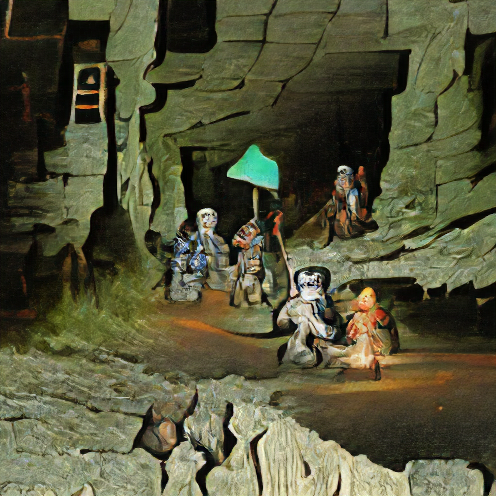

i: 50, loss: 0.551326, losses: 0.551326


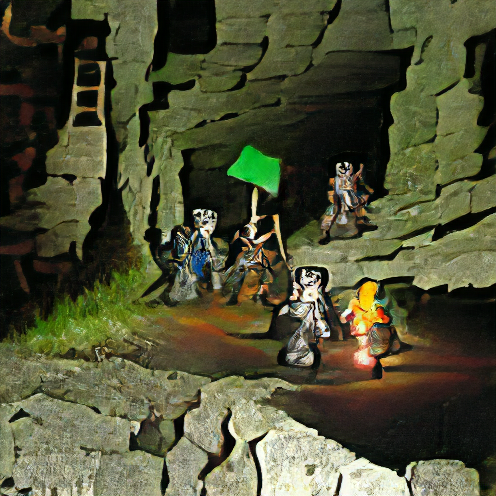

i: 100, loss: 0.55256, losses: 0.55256


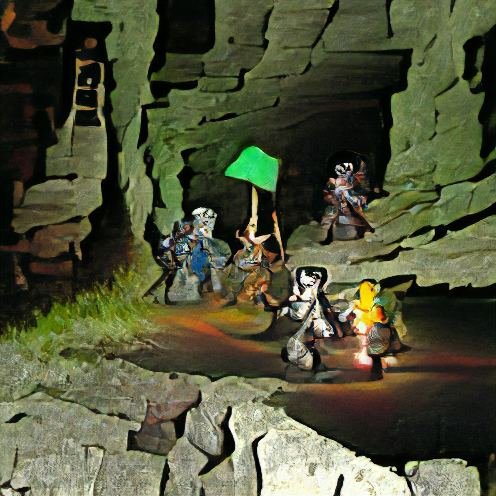

i: 150, loss: 0.542605, losses: 0.542605


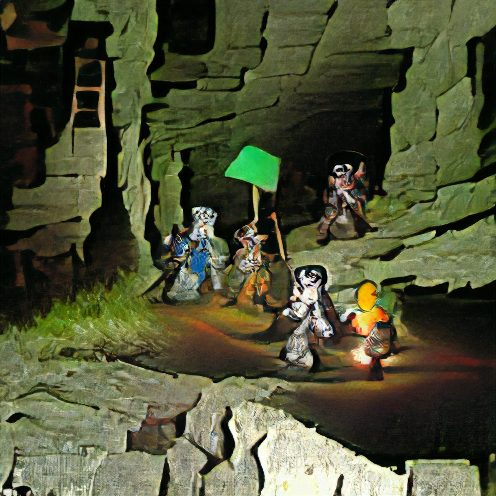

i: 200, loss: 0.552426, losses: 0.552426


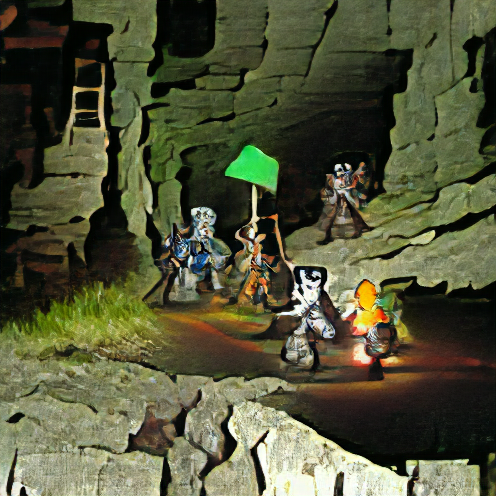

i: 250, loss: 0.549999, losses: 0.549999


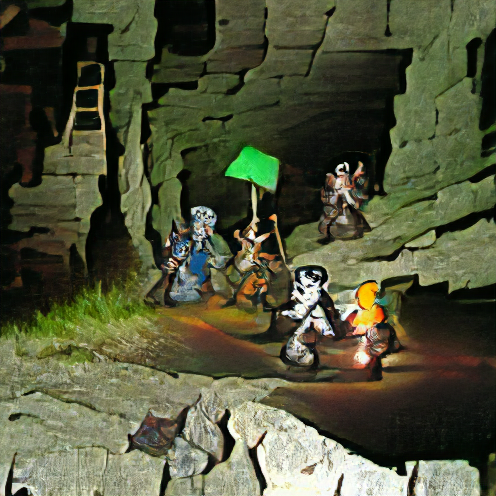

i: 300, loss: 0.55748, losses: 0.55748


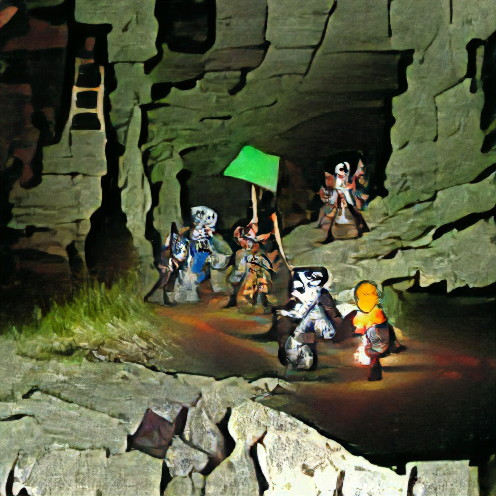

i: 350, loss: 0.546519, losses: 0.546519


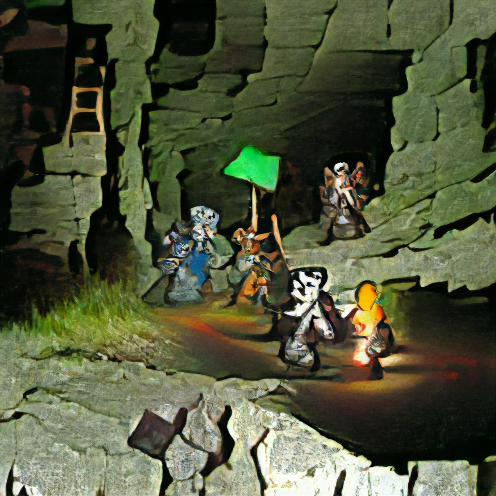

i: 400, loss: 0.548842, losses: 0.548842


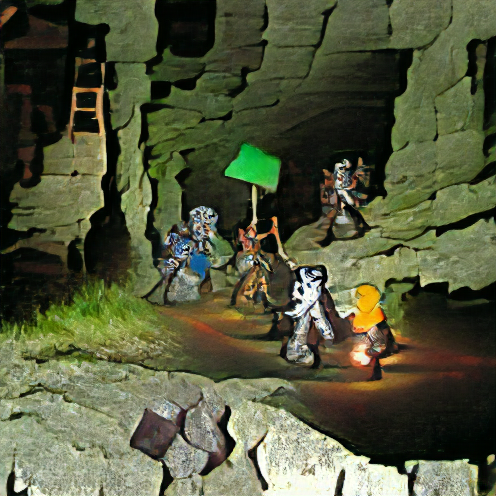

i: 450, loss: 0.547656, losses: 0.547656


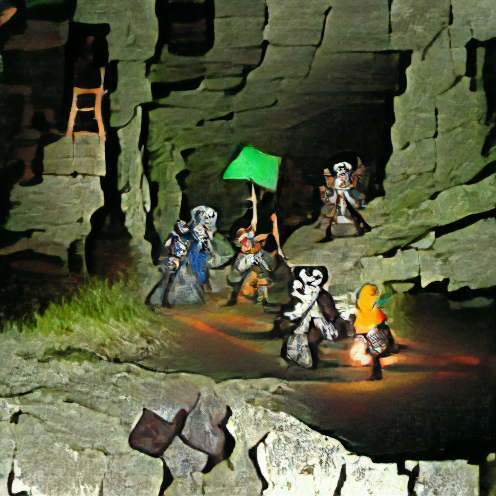

i: 500, loss: 0.545452, losses: 0.545452


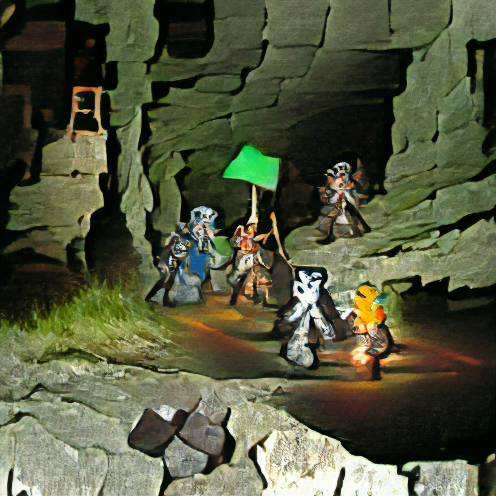

i: 550, loss: 0.533929, losses: 0.533929


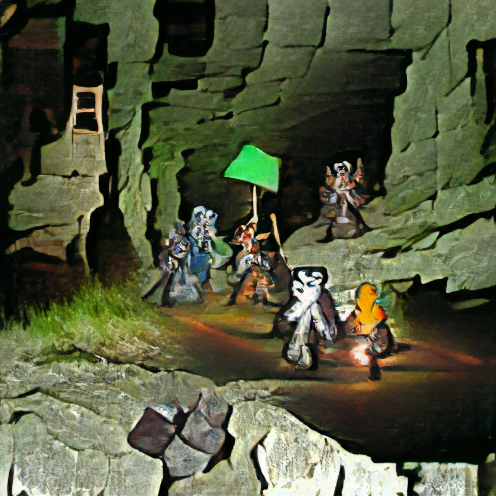

In [ ]:
#@title Run the Art Generator 

# text_prompts = ['unreal engine', 'center of the universe']
text_prompts = text
for prompt in text_prompts:
  device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
  print('Using device:', device)
  if text:
      print('Using texts:', text)
  if objective_image:
      print('Using image prompts:', objective_image)
  if args.seed is None:
      seed = torch.seed()
  else:
      seed = args.seed
  torch.manual_seed(seed)
  print('Using seed:', seed)

  model = load_vqgan_model(args.vqgan_config, args.vqgan_checkpoint).to(device)
  perceptor = clip.load(args.clip_model, jit=False)[0].eval().requires_grad_(False).to(device)

  cut_size = perceptor.visual.input_resolution
  if is_gumbel:
      e_dim = model.quantize.embedding_dim
  else:
      e_dim = model.quantize.e_dim

  f = 2**(model.decoder.num_resolutions - 1)
  make_cutouts = MakeCutouts(cut_size, args.cutn, cut_pow=args.cut_pow)
  if is_gumbel:
      n_toks = model.quantize.n_embed
  else:
      n_toks = model.quantize.n_e

  toksX, toksY = args.size[0] // f, args.size[1] // f
  sideX, sideY = toksX * f, toksY * f
  if is_gumbel:
      z_min = model.quantize.embed.weight.min(dim=0).values[None, :, None, None]
      z_max = model.quantize.embed.weight.max(dim=0).values[None, :, None, None]
  else:
      z_min = model.quantize.embedding.weight.min(dim=0).values[None, :, None, None]
      z_max = model.quantize.embedding.weight.max(dim=0).values[None, :, None, None]

  if args.init_image:
      pil_image = Image.open(args.init_image).convert('RGB')
      pil_image = pil_image.resize((sideX, sideY), Image.LANCZOS)
      z, *_ = model.encode(TF.to_tensor(pil_image).to(device).unsqueeze(0) * 2 - 1)
  else:
      one_hot = F.one_hot(torch.randint(n_toks, [toksY * toksX], device=device), n_toks).float()
      if is_gumbel:
          z = one_hot @ model.quantize.embed.weight
      else:
          z = one_hot @ model.quantize.embedding.weight
      z = z.view([-1, toksY, toksX, e_dim]).permute(0, 3, 1, 2)
  z_orig = z.clone()
  z.requires_grad_(True)
  opt = optim.Adam([z], lr=args.step_size)

  normalize = transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073],
                                  std=[0.26862954, 0.26130258, 0.27577711])

  pMs = []

  for prompt in args.prompts:
      txt, weight, stop = parse_prompt(prompt)
      embed = perceptor.encode_text(clip.tokenize(txt).to(device)).float()
      pMs.append(Prompt(embed, weight, stop).to(device))

  for prompt in args.image_prompts:
      path, weight, stop = parse_prompt(prompt)
      img = resize_image(Image.open(path).convert('RGB'), (sideX, sideY))
      batch = make_cutouts(TF.to_tensor(img).unsqueeze(0).to(device))
      embed = perceptor.encode_image(normalize(batch)).float()
      pMs.append(Prompt(embed, weight, stop).to(device))

  for seed, weight in zip(args.noise_prompt_seeds, args.noise_prompt_weights):
      gen = torch.Generator().manual_seed(seed)
      embed = torch.empty([1, perceptor.visual.output_dim]).normal_(generator=gen)
      pMs.append(Prompt(embed, weight).to(device))

  def synth(z):
      if is_gumbel:
          z_q = vector_quantize(z.movedim(1, 3), model.quantize.embed.weight).movedim(3, 1)
      else:
          z_q = vector_quantize(z.movedim(1, 3), model.quantize.embedding.weight).movedim(3, 1)
      
      return clamp_with_grad(model.decode(z_q).add(1).div(2), 0, 1)

  def add_xmp_data(nombrefichero):
      imagen = ImgTag(filename=nombrefichero)
      imagen.xmp.append_array_item(libxmp.consts.XMP_NS_DC, 'creator', 'VQGAN+CLIP', {"prop_array_is_ordered":True, "prop_value_is_array":True})
      if args.prompts:
          imagen.xmp.append_array_item(libxmp.consts.XMP_NS_DC, 'title', " | ".join(args.prompts), {"prop_array_is_ordered":True, "prop_value_is_array":True})
      else:
          imagen.xmp.append_array_item(libxmp.consts.XMP_NS_DC, 'title', 'None', {"prop_array_is_ordered":True, "prop_value_is_array":True})
      imagen.xmp.append_array_item(libxmp.consts.XMP_NS_DC, 'i', str(i), {"prop_array_is_ordered":True, "prop_value_is_array":True})
      imagen.xmp.append_array_item(libxmp.consts.XMP_NS_DC, 'model', model_name, {"prop_array_is_ordered":True, "prop_value_is_array":True})
      imagen.xmp.append_array_item(libxmp.consts.XMP_NS_DC, 'seed',str(seed) , {"prop_array_is_ordered":True, "prop_value_is_array":True})
      imagen.xmp.append_array_item(libxmp.consts.XMP_NS_DC, 'input_images',str(input_images) , {"prop_array_is_ordered":True, "prop_value_is_array":True})
      #for frases in args.prompts:
      #    imagen.xmp.append_array_item(libxmp.consts.XMP_NS_DC, 'Prompt' ,frases, {"prop_array_is_ordered":True, "prop_value_is_array":True})
      imagen.close()

  def add_stegano_data(filename):
      data = {
          "title": " | ".join(args.prompts) if args.prompts else None,
          "notebook": "VQGAN+CLIP",
          "i": i,
          "model": model_name,
          "seed": str(seed),
          "input_images": input_images
      }
      lsb.hide(filename, json.dumps(data)).save(filename)

  @torch.no_grad()
  def checkin(i, losses):
      losses_str = ', '.join(f'{loss.item():g}' for loss in losses)
      tqdm.write(f'i: {i}, loss: {sum(losses).item():g}, losses: {losses_str}')
      out = synth(z)
      TF.to_pil_image(out[0].cpu()).save('progress.png')
      add_stegano_data('progress.png')
      add_xmp_data('progress.png')
      display.display(display.Image('progress.png'))

  def ascend_txt():
      global i
      out = synth(z)
      iii = perceptor.encode_image(normalize(make_cutouts(out))).float()

      result = []

      if args.init_weight:
          result.append(F.mse_loss(z, z_orig) * args.init_weight / 2)

      for prompt in pMs:
          result.append(prompt(iii))
      img = np.array(out.mul(255).clamp(0, 255)[0].cpu().detach().numpy().astype(np.uint8))[:,:,:]
      img = np.transpose(img, (1, 2, 0))
      filename = f"steps/{i:04}.png"
      imageio.imwrite(filename, np.array(img))
      add_stegano_data(filename)
      add_xmp_data(filename)
      return result

  def train(i):
      opt.zero_grad()
      lossAll = ascend_txt()
      if i % args.display_freq == 0:
          checkin(i, lossAll)
      loss = sum(lossAll)
      loss.backward()
      opt.step()
      with torch.no_grad():
          z.copy_(z.maximum(z_min).minimum(z_max))

  i = 0
  try:
      with tqdm() as pbar:
          while True:
              train(i)
              if i == max_iteraciones:
                  break
              i += 1
              pbar.update()
  except KeyboardInterrupt:
      pass

In [28]:
#@markdown #**Optional Step --- Generate a video from generated frames**
init_frame = 1 # The start frame of the video being generated
last_frame = i # The last frame of the video that being generated. It will raise an error if that frame number does not exist.

min_fps = 10
max_fps = 30

total_frames = last_frame-init_frame

length = 15 # Duration of the video in seconds

frames = []
tqdm.write('Generating the video...')
for i in range(init_frame,last_frame): #
    filename = f"steps/{i:04}.png"
    frames.append(Image.open(filename))

#fps = last_frame/10
fps = np.clip(total_frames/length,min_fps,max_fps)

from subprocess import Popen, PIPE
p = Popen(['ffmpeg', '-y', '-f', 'image2pipe', '-vcodec', 'png', '-r', str(fps), '-i', '-', '-vcodec', 'libx264', '-r', str(fps), '-pix_fmt', 'yuv420p', '-crf', '17', '-preset', 'veryslow', 'video.mp4'], stdin=PIPE)
for im in tqdm(frames):
    im.save(p.stdin, 'PNG')
p.stdin.close()

print("The video is now being compressed...")
p.wait()
print("Video generation is now complete.")

Generando video...


  0%|          | 0/999 [00:00<?, ?it/s]

El vídeo está siendo ahora comprimido, espera...

El vídeo está listo

In [30]:
# @markdown #Show Video in Colab
mp4 = open('video.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
display.HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

In [31]:
# @markdown # Download Video
from google.colab import files
files.download("video.mp4")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Additional References



### Enhance The Resulting Image
Want to enhance the generated image with another AI?  This notebook may be of use to you. Enhances a 500x500 image to 1760x1760 with no quality loss.

The Notebook can be found [here](https://colab.research.google.com/drive/1O8kr-iyRll5eQsaOH-vQIc3ImEKWsvF-?usp=sharing)



### Add a Watermark to the Generated Image
Want to share your art, but dont want anyone to steal it? Watermark it using this [Colab Notebook](https://colab.research.google.com/drive/1OjKvOEYUOA8d1sMPL3hBVeCryGxZW-e2?usp=sharing) 


# **TODO:** ESRGAN for increasing resolution
---
<br>

- **SEEMS TO ONLY WORK CONSISTENTLY ON CHROME!**
- **DOUBLE CHECK YOUR RUNTIME TYPE IS SET TO GPU**

  > **Example**: an image with height 500px by width 500px scaled to an image with height 1762px by width 1762px

- **You might need to go to Runtime => Restart Runtime**

<br>

---

<br>
If you open the folder icon (in the left menu) you will see all your files, the good thing about doing **Runtime>Restart Runtime** is that it keeps all the files you downloaded but Restarts the Memory on the Cloud Computer so you can put the ESRGAN model in memory, compared to **Runtime>Factory Reset Runtime** which Restarts the whole Cloud Computer to a default clear state.
